# PET/CT and CT-derived facial landmark identification

*MVA Project 2022-2023*

*Authors: Emma Bou Hanna & Sebastian Partarrieu*

In this notebook, we use PET and CT scans to perform facial reconstruction. The main focus here is to explore the possibility of identifying facial landmarks on the reconstructed faces. We use this as a metric for facial reconstruction as well-reconstructed faces will give good landmark identification. 

## Data imports

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/MVA/projet_medecin/

/content/gdrive/MyDrive/MVA/projet_medecin


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import glob

In [ ]:
## store all filenames
list_ct_names = []
list_ct_res_names = [] 
list_suv_names = []
for path, subdirs, files in os.walk("./subset_emma_sebastian"):
  for fname in files:
    if fname.startswith('CTres'):
      list_ct_res_names.append(os.path.join(path, fname))
    elif fname.startswith('CT'):
      list_ct_names.append(os.path.join(path, fname))
    elif fname.startswith('SUV'):
      list_suv_names.append(os.path.join(path, fname))

In [ ]:
ct_scans = np.array(list_ct_res_names)
pet_scans = np.array(list_suv_names)

## Helpers

In [5]:
from skimage.filters import threshold_otsu, threshold_multiotsu
import seaborn as sns
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
sns.set_style('dark')

In [7]:
!pip install connected-components-3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 43.9 MB/s eta 0:00:00


In [8]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.3
    Uninstalling nbformat-5.7.3:
      Successfully uninstalled nbformat-5.7.3


In [9]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 42.2 MB/s eta 0:00:00


In [10]:
# import cc3d
# import open3d as o3d
from skimage.color import rgb2gray
import cv2
from skimage import measure
import mediapipe as mp

In [11]:
def add_face_box_to_img(image, convert=True):
  '''
  Face bounding box obtained with open cv haar cascades.
  Image modified inplace!
  '''
  face_cascade_name = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
  haar_cascade = cv2.CascadeClassifier(face_cascade_name)
  faces_rect = haar_cascade.detectMultiScale(image, scaleFactor = 1.1,
                                             minNeighbors = 3, minSize=(100, 100))
  color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  for (x,y,w,h) in faces_rect:
     cv2.rectangle(color_img, (x, y), (x+w, y+h), (220, 20, 60), 2)
  return color_img, faces_rect

In [12]:
def add_facial_landmarks(mp_drawing,
                         mp_face_mesh,
                         mp_drawing_styles,
                         results, image):
  if results.multi_face_landmarks:
    counter = 0
    for face_landmarks in results.multi_face_landmarks:
      mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
      counter += 1
      return image, counter
  else:
    return image, 0

In [13]:
def plot(img1, img2, title1, title2):
  f, axs = plt.subplots(1, 2, figsize=(12, 6))
  axs[0].imshow(img1, cmap='gray')
  axs[0].axis('off')
  axs[0].set(title=title1)

  axs[1].imshow(img2, cmap='gray')
  axs[1].axis('off')
  axs[1].set(title=title2)
  plt.show()

### With preprocessed images

In [20]:
from skimage.restoration import denoise_nl_means, denoise_wavelet, estimate_sigma

In [14]:
##newer face detection
def add_face_detection(mp_drawing,
                       results, 
                       image):
  if results.detections:
    counter = 0
    annotated_image = image.copy()
    for detection in results.detections:
      mp_drawing.draw_detection(annotated_image, detection)
      counter += 1
    return annotated_image, counter
  else:
    return image, 0

In [15]:
def normalization_eyes(results, mp_face_mesh):
  """
  Get the interocular distance in the ct img with landmarks
  """
  mesh = np.array([(p.x, p.y) for p in results.multi_face_landmarks[0].landmark])

  # find landmark indices for eyes
  left_eye_idx = np.unique(list(mp_face_mesh.FACEMESH_LEFT_EYE))
  right_eye_idx = np.unique(list(mp_face_mesh.FACEMESH_RIGHT_EYE))

  # get midpoint for left eye
  left_eye = sorted(mesh[left_eye_idx], key=lambda x: x[0])
  left_eye_pt = (.5*(left_eye[-1][0] + left_eye[0][0]), .5*(left_eye[-1][1] + left_eye[0][1]))

  # get midpoint for right eye
  right_eye = sorted(mesh[right_eye_idx], key=lambda x: x[0])
  right_eye_pt = (.5*(right_eye[-1][0] + right_eye[0][0]), .5*(right_eye[-1][1] + right_eye[0][1]))

  # get normalized distance between both midpoints
  return right_eye_pt, left_eye_pt, np.linalg.norm(np.array(right_eye_pt) - np.array(left_eye_pt))

In [16]:
def get_distance_landmarks(res_ct, res_pet, mp_face_mesh, iod=None):
  """
  Implement the mean absolute distance betwwen the vertex locations,
  normalized by the distance between the eye centers (Interocular distance)
  """
  if res_ct.multi_face_landmarks is None or res_pet.multi_face_landmarks is None:
    print("Cannot compute the distance")
    return 

  # don't use normalization
  if iod is None:
    iod = 1
    
  mesh_ct = np.array([(p.x, p.y) for p in res_ct.multi_face_landmarks[0].landmark])
  mesh_pet = np.array([(p.x, p.y) for p in res_pet.multi_face_landmarks[0].landmark])
  return 100*np.sum(np.abs(mesh_ct - mesh_pet))/(iod*mp_face_mesh.FACEMESH_NUM_LANDMARKS)


In [17]:
pet_imgs = glob.glob('./data_img/pets/*.png')
ct_imgs = glob.glob('./data_img/cts/*.png')

In [18]:
ct_ids = [x.split('/')[-1] for x in ct_imgs]
pet_ids = [x.split('/')[-1] for x in pet_imgs]

assert ct_ids == pet_ids

In [19]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
mp_face_detection = mp.solutions.face_detection

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  max_num_faces=1,
                                  refine_landmarks=True,
                                  min_detection_confidence=0.5)

face_detection = mp_face_detection.FaceDetection(model_selection=1,
                                                 min_detection_confidence=0.5)

In [21]:
landmarks_detected_pet = 0
landmarks_detected_ct = 0
landmarks_detected_pet_denoised = 0
crop_size = 150
mad_list = []
mad_list_denoised = []

for i, (pet, ct) in enumerate(zip(pet_imgs, ct_imgs)):
  # read img
  pet_img = cv2.imread(pet, cv2.IMREAD_GRAYSCALE)
  ct_img = cv2.imread(ct, cv2.IMREAD_GRAYSCALE)

  # Crop imgs
  pet_img = pet_img[crop_size:-crop_size, crop_size:-crop_size]
  ct_img = ct_img[crop_size:-crop_size, crop_size:-crop_size]

  pet_img = pet_img/255.
  #add denoising
  pet_img_denoise = denoise_wavelet(pet_img,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)
  
  pet_img = (pet_img*255).astype(np.uint8)
  pet_img_denoise = (pet_img_denoise*255).astype(np.uint8)
  
  # Transform to RGB
  pet_img = cv2.cvtColor(pet_img, cv2.COLOR_GRAY2RGB)
  ct_img = cv2.cvtColor(ct_img, cv2.COLOR_GRAY2RGB)
  pet_img_denoise =  cv2.cvtColor(pet_img_denoise, cv2.COLOR_GRAY2RGB)

  #facial landmarks
  results_ct = face_mesh.process(ct_img)
  results_pet = face_mesh.process(pet_img)
  results_pet_den =  face_mesh.process(pet_img_denoise)
  
  #add to plot
  ct_img, counter_landmarks_ct = add_facial_landmarks(mp_drawing,
                                mp_face_mesh,
                                mp_drawing_styles,
                                results_ct, ct_img)
  
  pet_img, counter_landmarks_pet = add_facial_landmarks(mp_drawing,
                                mp_face_mesh,
                                mp_drawing_styles,
                                results_pet, pet_img)
  
  pet_img_denoise, counter_landmarks_pet_den = add_facial_landmarks(mp_drawing,
                                mp_face_mesh,
                                mp_drawing_styles,
                                results_pet_den, pet_img_denoise)
  
  #update
  if counter_landmarks_ct == 1:
    landmarks_detected_ct += 1

  if counter_landmarks_pet == 1:
    landmarks_detected_pet += 1

  if counter_landmarks_pet_den == 1:
    landmarks_detected_pet_denoised += 1

  if i % 50 == 0:
    if (counter_landmarks_ct == 1) or (counter_landmarks_pet == 1):
      plot(ct_img, pet_img, 'CT face detection', 'PET face detection')
  
  if (counter_landmarks_ct == 1) and (counter_landmarks_pet == 1):
    right_eye_pt, left_eye_pt, iod = normalization_eyes(results_ct, mp_face_mesh)
    mad = get_distance_landmarks(results_ct, results_pet, mp_face_mesh, iod)
    mad_list.append(mad)
    if i % 50 == 0:
      print(f"Mean Absolute Distance between PET & CT landmarks = {mad} %")
  
  if (counter_landmarks_ct == 1) and (counter_landmarks_pet_den == 1):
    right_eye_pt, left_eye_pt, iod = normalization_eyes(results_ct, mp_face_mesh)
    mad = get_distance_landmarks(results_ct, results_pet_den, mp_face_mesh, iod)
    mad_list_denoised.append(mad)
    if i % 50 == 0:
      print(f"Mean Absolute Distance between PET denoised & CT landmarks = {mad} %")
  

Output hidden; open in https://colab.research.google.com to view.

In [26]:
good_landmarks_pet = np.sum(np.array(mad_list) < 15.)
good_landmarks_pet /= len(pet_imgs)

good_landmarks_pet_den = np.sum(np.array(mad_list_denoised) < 15.)
good_landmarks_pet_den /= len(pet_imgs)

In [29]:
height = [landmarks_detected_ct/len(pet_imgs),
          landmarks_detected_pet/len(pet_imgs),
          landmarks_detected_pet_denoised/len(pet_imgs),
          good_landmarks_pet,
          good_landmarks_pet_den]

bars = ['CT landmarks',
        'PET landmarks',
        'PET denoised landmarks',
        'Good landmarks PET',
        'Good landmarks PET denoised']

In [45]:
palette = sns.color_palette('husl')

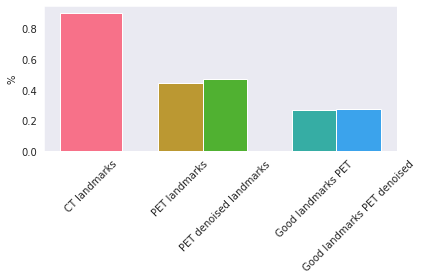

In [50]:
x_pos = [0., 1., 1.5, 2.5, 3.]

plt.bar(x_pos, height,
        color=palette[:5],
        width=[.7, .5, .5, .5, .5])

plt.xticks(x_pos, bars, rotation=45)
plt.ylabel('%')
plt.tight_layout()
plt.savefig('./figs/face_boxplots.png', dpi=300)
plt.show()

In [53]:
df_plot = pd.DataFrame(mad_list_denoised)

In [55]:
df_plot.columns = ['PET_denoised']

In [57]:
df_plot['PET'] = 0
df_plot['PET'].iloc[:len(mad_list)] = mad_list

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [62]:
df_plot['PET'].replace(0., np.nan, inplace=True)

In [65]:
df_plot = df_plot.melt(value_vars=['PET_denoised', 'PET'], var_name='Denoised_status', value_name='MAD')

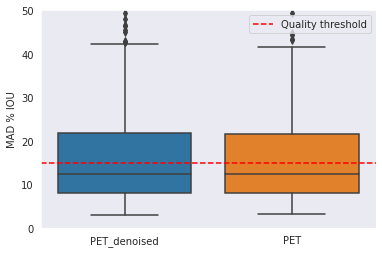

In [84]:
sns.boxplot(data=df_plot, x='Denoised_status', y='MAD')
plt.ylim((0, 50.))
plt.ylabel('MAD % IOU')
plt.xlabel('')
plt.axhline(15, linestyle='--', c='red', label='Quality threshold')
plt.legend(loc="upper right")
plt.show()

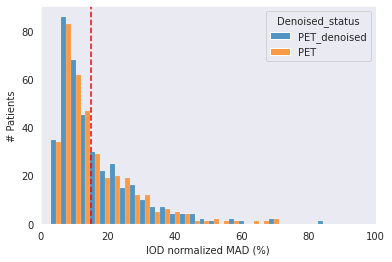

In [100]:
sns.histplot(data=df_plot, hue='Denoised_status', x='MAD',
             multiple='dodge', stat='count', common_norm=False)
plt.ylabel('# Patients')
plt.xlabel('IOD normalized MAD (%)')
plt.axvline(15, linestyle='--', c='red')
#plt.legend(loc="upper right")
plt.xlim((0, 100))
plt.show()